In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
from tools import *
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats
from scipy.stats import multivariate_normal
from scipy.misc import derivative
from scipy.linalg import fractional_matrix_power
from scipy.stats import wishart
from IPython.display import Latex
import sys
import time

In [3]:
def logtargetpdf(x, target, mu=0, sigma=1):
    lnp = 0.0
    if (target == 'Exp'):
            lnp = -(x-mu)/sigma if (x>=mu) else -500
    elif (target == 'Folded_Gaussian'):
            lnp = -(x-mu)**2/(2*sigma**2) if (x>=mu) else -500
    elif (target == 'N01_T2'):
            lnp = -(x-mu)**2/(2*sigma**2)
    elif (target == 'N01_Logistic'):
            lnp = -(x-mu)**2/(2*sigma**2)
    return (lnp)

def transform_x(x,transform,mu=0,sigma=1):
    y = 0.0
    x = (x-mu)/sigma
    if (transform == 'Exp(1)_CDF'):
        y = np.exp(-x)
    elif (transform == 't2_CDF'):
        y = 1/2+x/np.sqrt(8+4*x**2)
    elif (transform == 'logistic_CDF'):
        y = 1/(1+np.exp(-x))
    return y

def transform_inverse(y,transform,mu=0,sigma=1):
    x = 0.0
    if (transform == 'Exp(1)_CDF'):
        x = -np.log(y)
    elif (transform == 't2_CDF'):
        x = (2*y-1)/np.sqrt(2*y*(1-y))
    elif (transform == 'logistic_CDF'):
        x = -np.log(1/y-1)
    x = x * sigma + mu
    return x

def log_proposal_ratio(x,transform,burnin_off,kernel,mu=0,sigma=1):
    ratio = 0.0
    if ('Trans' in kernel)&burnin_off:
        x = (x-mu)/sigma
        if (transform == 'Exp(1)_CDF'):
            ratio = -x
        elif (transform == 't2_CDF'):
            ratio = -3/2*np.log(2+x**2)# - np.log(sigma)
        elif (transform == 'logistic_CDF'):
            ratio = -x - 2*np.log(1+np.exp(-x))# - np.log(sigma)
    return ratio

In [4]:
#MCMC sampling implementation
np.random.seed(121)
begin_total = time.time()
nround = int(10e5)
burnin = int(2*10e4)
size = len(range(-burnin,nround))
sigmaset_baseline = np.array([0.1, 0.3, 0.5, 0.7, 0.8, 0.9, 1, 1.1, 1.3, 1.5, 1.7,
                    1.8, 1.9, 2, 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.8,
                    3.0, 3.2, 3.5, 4, 4.5, 5, 6, 7, 8])
kernelset = ['Uniform','TransUniform','TransBactrian','TransStrawHat']
targetset = {'N01_T2':'t2_CDF', 'N01_Logistic':'logistic_CDF'}
# kernelset = ['Uniform']
# targetset = {'N01_T2':'t2_CDF'}

target_result = {}
mu=0;std=1
for target,transform in targetset.items():
    eff_kernel = {}; Pjump_kernel = {}; Exx2_kernel = {}; Rho_kernel={}; Sample_kernel={}; Quantile_kernel={}
    for kernel in kernelset:
        Eff = []; Pjump = []; Exx2=[]; Rho=[]; Sample=[]; Quantile=[]
        if 'Uniform' in kernel:
            random_result = np.random.uniform(low=-np.sqrt(3), high=np.sqrt(3), size=size)
        elif 'Bactrian' in kernel:
            random_result = random_bactrian(size = size)
        elif 'StrawHat' in kernel:
            random_result = random_strawhat(size=size)
        sigmaset = sigmaset_baseline if 'Trans' in kernel else (np.append(sigmaset_baseline,[10,15,20,27]))*std
        for sigma in sigmaset:
            begin_loop = time.time()
            exx2 = 0; accept = 0; burn_in_result = []
            x = np.random.uniform(low=mu,high=mu+1)
            result = np.zeros(nround)
            logpdf_old = logtargetpdf(x,target,mu=mu,sigma=std) - log_proposal_ratio(x,transform,True,kernel,mu=mu,sigma=std)
            mu_hat, sigma_hat = mu,std
            burnin_off=False
            for j in range(-burnin,nround):
                if (j==0):
                    accept = 0; burnin_off = True
                    mu_hat, sigma_hat = np.mean(burn_in_result), np.std(burn_in_result)
                y = x if (not(('Trans' in kernel)&burnin_off)) else transform_x(x,transform,mu=mu_hat,sigma=sigma_hat)
                ynew = y + random_result[j+burnin] * sigma
                if ((('Trans' in kernel)&burnin_off) & (not (0 <= ynew <= 1))):
                    ynew = reflect(ynew, xL=0, xU=1)
                xnew = ynew if (not(('Trans' in kernel)&burnin_off)) else transform_inverse(ynew,transform,mu=mu_hat,sigma=sigma_hat)
                logpdf_new = logtargetpdf(xnew,target,mu=mu,sigma=std) - log_proposal_ratio(xnew,transform,burnin_off,kernel,mu=mu_hat,sigma=sigma_hat)
                pi_dif = logpdf_new - logpdf_old
                if ((pi_dif>0) | (np.exp(pi_dif)>np.random.random())):
                    x = xnew
                    logpdf_old = logpdf_new
                    accept += 1
                
                if (j<0):
                    burn_in_result.append(x)
                else:
                    result[j] = x
                    
            eff = Eff_IntegratedCorrelationTime(result)
            rho = [rho_k(result,i) for i in range(1,11)]
            exx2 = sum(np.square(result[1:] - result[:-1]))
            quantile = [Eff_quantile(result,i) for i in [0.05,0.25,0.5,0.75,0.95]]
            Eff.append(eff)
            Pjump.append(accept/nround)
            Exx2.append(exx2/nround)
            Rho.append(rho)
            Sample.append(result.copy())
            Quantile.append(quantile)
            display(Latex('Target:{} | Kernel:{} | $\sigma$:{} | eff:{} | $P_{{jump}}$:{} | Exx2:{} | $\\rho_1$:{} | $\\rho_2$:{} | $E_{{0.05}}$:{} | $E_{{0.25}}$:{} | $E_{{0.50}}$:{} | Time:{}'.format(
                    target,kernel,sigma,round(eff,4),round(accept/nround,4),round(exx2/nround,4),round(rho[0],4),round(rho[1],4),
                    round(quantile[0],4),round(quantile[1],4),round(quantile[2],4),round((time.time()-begin_loop),2))))
        eff_kernel[kernel] = Eff
        Pjump_kernel[kernel] = Pjump
        Exx2_kernel[kernel] = Exx2
        Rho_kernel[kernel] = Rho
        Sample_kernel[kernel] = Sample
        Quantile_kernel[kernel] = Quantile
    target_result[target] = [eff_kernel,Pjump_kernel,Exx2_kernel,Rho_kernel,Sample_kernel,Quantile_kernel]
print('总共用时: %f'% (time.time()-begin_total))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

总共用时: 4276.751987


In [101]:
sigmaset_baseline = np.array([0.1, 0.3, 0.5, 0.7, 0.8, 0.9, 1, 1.1, 1.3, 1.5, 1.7,
                    1.8, 1.9, 2, 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.8,
                    3.0, 3.2, 3.5, 4, 4.5, 5, 6, 7, 8])
sigmaset_trans = sigmaset_baseline*np.sqrt(12)
append = np.array([10,15,20,27])
sigmaset_uniform = np.append(sigmaset_baseline,append)
sigmaset = np.array([sigmaset_uniform,sigmaset_trans,sigmaset_trans,sigmaset_trans])

### Optimize the Efficiency of 5% quantile

In [102]:
name = ['Kernel' ,'Sigma', 'Eff', 'Pjump', 'Exx2', 'rho1', 'rho2', 'E_5%', 'E_25%', 'E_50%']
print('{:<25} {:<8} {:<8} {:<8} {:<8} {:<8} {:<8} {:<8} {:<8} {:<8}'.format(*name))

for target in targetset:
    kernel_info = {}
    print('                                      ',target)
    for kernel in kernelset:
        index = [np.argmax([target_result[target][5][j][i][0] for i in range(30)]) for j in kernelset]
        index_need = index[np.where(np.array(kernelset)==kernel)[0][0]]
        info = [target_result[target][i][kernel][index_need] for i in range(len(target_result[target]))]
        rho1 = info[3][0]; rho2 = info[3][1]
        E05 = info[5][0]; E25 = info[5][1]; E50 = info[5][2]
        kernel_index = 0 if kernel == 'Uniform' else 1
        kernel_info[kernel] = np.round(np.concatenate([[sigmaset[kernel_index][index_need]],info[0:3],[rho1,rho2],[E05,E25,E50]]),3)
        kernel_info[kernel] = kernel_info[kernel].tolist()
        kernel_info[kernel].insert(0,kernel)
        print('{:<25} {:<8} {:<8} {:<8} {:<8} {:<8} {:<8} {:<8} {:<8} {:<8}'.format(*kernel_info[kernel]))

Kernel                    Sigma    Eff      Pjump    Exx2     rho1     rho2     E_5%     E_25%    E_50%   
                                       N01_T2
Uniform                   2.2      0.274    0.407    0.88     0.561    0.318    0.299    0.252    0.239   
TransUniform              3.464    0.904    0.826    1.902    0.051    0.003    0.823    0.794    0.833   
TransBactrian             1.732    0.776    0.806    1.766    0.116    0.02     1.014    0.84     0.642   
TransStrawHat             1.732    0.843    0.802    1.853    0.073    0.015    1.003    0.967    0.586   
                                       N01_Logistic
Uniform                   2.0      0.276    0.441    0.878    0.561    0.319    0.296    0.277    0.261   
TransUniform              3.464    0.777    0.683    1.774    0.112    0.019    0.735    0.604    0.575   
TransBactrian             1.732    0.644    0.584    1.634    0.184    0.055    0.951    0.529    0.356   
TransStrawHat             1.732    0.637    0.

### Optimize the Efficiency of 25% quantile

In [103]:
name = ['Kernel' ,'Sigma', 'Eff', 'Pjump', 'Exx2', 'rho1', 'rho2', 'E_5%', 'E_25%', 'E_50%']
print('{:<25} {:<8} {:<8} {:<8} {:<8} {:<8} {:<8} {:<8} {:<8} {:<8}'.format(*name))

for target in targetset:
    kernel_info = {}
    print('                                      ',target)
    for kernel in kernelset:
        index = [np.argmax([target_result[target][5][j][i][1] for i in range(30)]) for j in kernelset]
        index_need = index[np.where(np.array(kernelset)==kernel)[0][0]]
        info = [target_result[target][i][kernel][index_need] for i in range(len(target_result[target]))]
        rho1 = info[3][0]; rho2 = info[3][1]
        E05 = info[5][0]; E25 = info[5][1]; E50 = info[5][2]
        kernel_index = 0 if kernel == 'Uniform' else 1
        kernel_info[kernel] = np.round(np.concatenate([[sigmaset[kernel_index][index_need]],info[0:3],[rho1,rho2],[E05,E25,E50]]),3)
        kernel_info[kernel] = kernel_info[kernel].tolist()
        kernel_info[kernel].insert(0,kernel)
        print('{:<25} {:<8} {:<8} {:<8} {:<8} {:<8} {:<8} {:<8} {:<8} {:<8}'.format(*kernel_info[kernel]))

Kernel                    Sigma    Eff      Pjump    Exx2     rho1     rho2     E_5%     E_25%    E_50%   
                                       N01_T2
Uniform                   1.7      0.253    0.499    0.834    0.582    0.346    0.28     0.295    0.288   
TransUniform              3.118    0.969    0.827    1.969    0.018    -0.001   0.786    0.83     0.839   
TransBactrian             2.425    1.273    0.819    2.257    -0.127   0.016    0.882    0.981    0.931   
TransStrawHat             3.811    1.671    0.832    2.507    -0.256   0.068    0.781    0.99     1.224   
                                       N01_Logistic
Uniform                   1.7      0.25     0.499    0.835    0.584    0.349    0.279    0.292    0.286   
TransUniform              2.771    0.819    0.716    1.821    0.09     0.015    0.672    0.626    0.626   
TransBactrian             3.464    1.316    0.723    2.281    -0.143   0.025    0.67     0.722    0.85    
TransStrawHat             3.464    1.475    0.

### Optimize the Efficiency of 50% quantile

In [104]:
name = ['Kernel' ,'Sigma', 'Eff', 'Pjump', 'Exx2', 'rho1', 'rho2', 'E_5%', 'E_25%', 'E_50%']
print('{:<25} {:<8} {:<8} {:<8} {:<8} {:<8} {:<8} {:<8} {:<8} {:<8}'.format(*name))

for target in targetset:
    kernel_info = {}
    print('                                      ',target)
    for kernel in kernelset:
        index = [np.argmax([target_result[target][5][j][i][2] for i in range(30)]) for j in kernelset]
        index_need = index[np.where(np.array(kernelset)==kernel)[0][0]]
        info = [target_result[target][i][kernel][index_need] for i in range(len(target_result[target]))]
        rho1 = info[3][0]; rho2 = info[3][1]
        E05 = info[5][0]; E25 = info[5][1]; E50 = info[5][2]
        kernel_index = 0 if kernel == 'Uniform' else 1
        kernel_info[kernel] = np.round(np.concatenate([[sigmaset[kernel_index][index_need]],info[0:3],[rho1,rho2],[E05,E25,E50]]),3)
        kernel_info[kernel] = kernel_info[kernel].tolist()
        kernel_info[kernel].insert(0,kernel)
        print('{:<25} {:<8} {:<8} {:<8} {:<8} {:<8} {:<8} {:<8} {:<8} {:<8}'.format(*kernel_info[kernel]))

Kernel                    Sigma    Eff      Pjump    Exx2     rho1     rho2     E_5%     E_25%    E_50%   
                                       N01_T2
Uniform                   1.5      0.229    0.544    0.777    0.611    0.382    0.266    0.291    0.295   
TransUniform              2.425    0.883    0.838    1.873    0.062    0.005    0.718    0.744    0.907   
TransBactrian             3.118    1.609    0.838    2.472    -0.237   0.062    0.769    0.933    1.38    
TransStrawHat             3.118    1.677    0.849    2.537    -0.272   0.095    0.666    0.833    1.736   
                                       N01_Logistic
Uniform                   1.5      0.225    0.543    0.773    0.613    0.385    0.263    0.286    0.293   
TransUniform              2.425    0.797    0.722    1.778    0.11     0.015    0.627    0.595    0.677   
TransBactrian             3.464    1.316    0.723    2.281    -0.143   0.025    0.67     0.722    0.85    
TransStrawHat             3.118    1.531    0.

### Optimize the Efficiency of mean value

In [105]:
name = ['Kernel' ,'Sigma', 'Eff', 'Pjump', 'Exx2', 'rho1', 'rho2', 'E_5%', 'E_25%', 'E_50%']
print('{:<25} {:<8} {:<8} {:<8} {:<8} {:<8} {:<8} {:<8} {:<8} {:<8}'.format(*name))

for target in targetset:
    kernel_info = {}
    print('                                      ',target)
    for kernel in kernelset:
        index = [np.argmax(target_result[target][0][i]) for i in kernelset]
        index_need = index[np.where(np.array(kernelset)==kernel)[0][0]]
        info = [target_result[target][i][kernel][index_need] for i in range(len(target_result[target]))]
        rho1 = info[3][0]; rho2 = info[3][1]
        E05 = info[5][0]; E25 = info[5][1]; E50 = info[5][2]
        kernel_index = 0 if kernel == 'Uniform' else 1
        kernel_info[kernel] = np.round(np.concatenate([[sigmaset[kernel_index][index_need]],info[0:3],[rho1,rho2],[E05,E25,E50]]),3)
        kernel_info[kernel] = kernel_info[kernel].tolist()
        kernel_info[kernel].insert(0,kernel)
        print('{:<25} {:<8} {:<8} {:<8} {:<8} {:<8} {:<8} {:<8} {:<8} {:<8}'.format(*kernel_info[kernel]))

Kernel                    Sigma    Eff      Pjump    Exx2     rho1     rho2     E_5%     E_25%    E_50%   
                                       N01_T2
Uniform                   2.1      0.277    0.423    0.878    0.558    0.316    0.298    0.266    0.251   
TransUniform              3.118    0.969    0.827    1.969    0.018    -0.001   0.786    0.83     0.839   
TransBactrian             3.118    1.609    0.838    2.472    -0.237   0.062    0.769    0.933    1.38    
TransStrawHat             3.464    1.749    0.84     2.565    -0.282   0.092    0.724    0.868    1.522   
                                       N01_Logistic
Uniform                   2.1      0.278    0.423    0.879    0.559    0.315    0.289    0.263    0.253   
TransUniform              3.118    0.825    0.695    1.828    0.084    0.017    0.705    0.617    0.57    
TransBactrian             3.464    1.316    0.723    2.281    -0.143   0.025    0.67     0.722    0.85    
TransStrawHat             3.118    1.531    0.

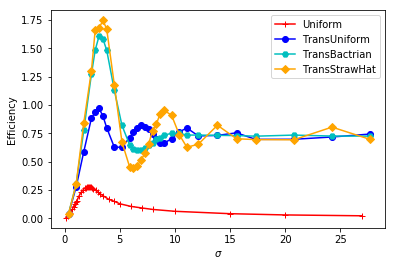

In [80]:
marker = ['+','o','H','D','*','4','>','p','P']
color = ['red','Blue','c','Orange','m','Black','green','Brown']
[plt.plot(sigmaset[i],target_result['N01_T2'][0][kernelset[i]],marker=marker[i],color=color[i],label=kernelset[i]) for i in range(4)]
plt.legend()
plt.xlabel('$\sigma$', fontsize=10)
plt.ylabel('Efficiency', fontsize=10)
plt.savefig('Eff_for_N01_T2.eps', format='eps', dpi=1000)
plt.show()

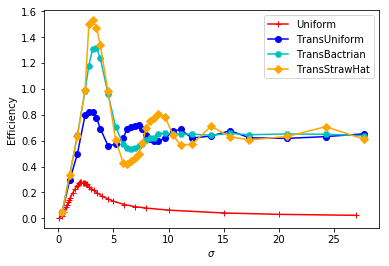

In [81]:
marker = ['+','o','H','D','*','4','>','p','P']
color = ['red','Blue','c','Orange','m','Black','green','Brown']
[plt.plot(sigmaset[i],target_result['N01_Logistic'][0][kernelset[i]],marker=marker[i],color=color[i],label=kernelset[i]) for i in range(4)]
plt.legend()
plt.xlabel('$\sigma$', fontsize=10)
plt.ylabel('Efficiency', fontsize=10)
plt.savefig('Eff_of_N01_logistic.eps', format='eps', dpi=1000)
plt.show()

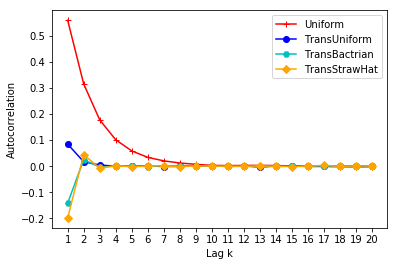

In [82]:
index = [np.argmax(target_result['N01_T2'][0][i]) for i in kernelset]
marker = ['+','o','H','D','*','4','>','p','P']
color = ['red','Blue','c','Orange','m','Black','green','Brown']
for j in range(4):
    rho50 = [rho_k(target_result['N01_Logistic'][4][kernelset[j]][index[j]],i) for i in range(1,21)]
    plt.plot(range(1,21),rho50,marker=marker[j],color=color[j],label=kernelset[j])
# plt.ylim(-0.2,0.2)
plt.legend()
plt.xticks(range(1, 21))
plt.xlabel('Lag k', fontsize=10)
plt.ylabel('Autocorrelation', fontsize=10)
plt.savefig('rho_of_N01_logistic.eps', format='eps', dpi=1000)
plt.show()

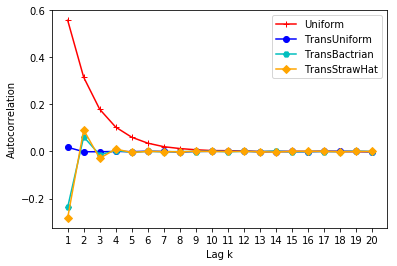

In [83]:
index = [np.argmax(target_result['N01_T2'][0][i]) for i in kernelset]
marker = ['+','o','H','D','*','4','>','p','P']
color = ['red','Blue','c','Orange','m','Black','green','Brown']
for j in range(4):
    rho50 = [rho_k(target_result['N01_T2'][4][kernelset[j]][index[j]],i) for i in range(1,21)]
    plt.plot(range(1,21),rho50,marker=marker[j],color=color[j],label=kernelset[j])
# plt.ylim(-0.2,0.2)
plt.legend()
plt.xticks(range(1, 21))
plt.xlabel('Lag k', fontsize=10)
plt.ylabel('Autocorrelation', fontsize=10)
plt.savefig('rho_of_N01_T2.eps', format='eps', dpi=1000)
plt.show()

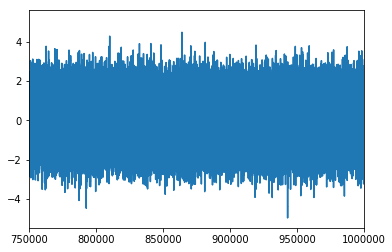

In [84]:
plt.plot(target_result['N01_T2'][4]['Uniform'][16])
# plt.xlim(700000,705000)
plt.xlim(750000,1000000)
plt.savefig('MCMC_uniform.eps', format='eps', dpi=1000)
plt.show()

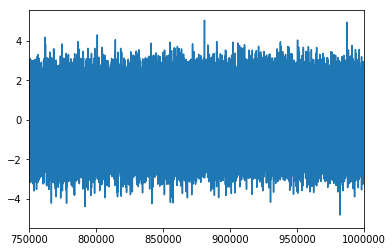

In [85]:
plt.plot(target_result['N01_T2'][4]['TransUniform'][5])
# plt.xlim(700000,705000)
plt.savefig('MCMC_TransUniform.eps', format='eps', dpi=1000)
plt.xlim(750000,1000000)
plt.show()

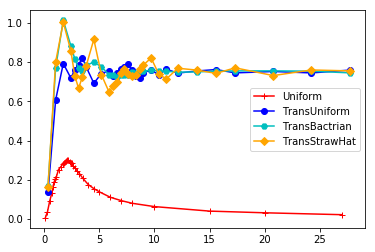

In [86]:
indexofquantile = 0
kernel = 'N01_T2'
marker = ['+','o','H','D','*','4','>','p','P']
color = ['red','Blue','c','Orange','m','Black','green','Brown']
for j in range(4):
    rg = 34 if j ==0 else 30
    result = [target_result[kernel][5][kernelset[j]][i][indexofquantile] for i in range(rg)]
    plt.plot(sigmaset[j],result,marker=marker[j],color=color[j],label=kernelset[j])
plt.legend()
plt.savefig('5quantile.eps', format='eps', dpi=1000)
plt.show()

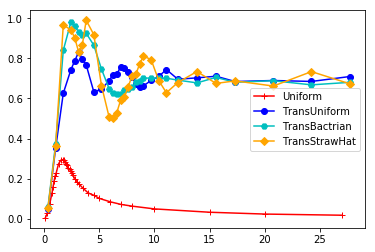

In [87]:
indexofquantile = 1
kernel = 'N01_T2'
marker = ['+','o','H','D','*','4','>','p','P']
color = ['red','Blue','c','Orange','m','Black','green','Brown']
for j in range(4):
    rg = 34 if j ==0 else 30
    result = [target_result[kernel][5][kernelset[j]][i][indexofquantile] for i in range(rg)]
    plt.plot(sigmaset[j],result,marker=marker[j],color=color[j],label=kernelset[j])
plt.legend()
plt.savefig('25quantile.eps', format='eps', dpi=1000)
plt.show()

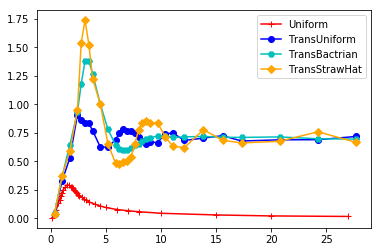

In [88]:
indexofquantile = 2
kernel = 'N01_T2'
marker = ['+','o','H','D','*','4','>','p','P']
color = ['red','Blue','c','Orange','m','Black','green','Brown']
for j in range(4):
    rg = 34 if j ==0 else 30
    result = [target_result[kernel][5][kernelset[j]][i][indexofquantile] for i in range(rg)]
    plt.plot(sigmaset[j],result,marker=marker[j],color=color[j],label=kernelset[j])
plt.legend()
plt.savefig('50quantile.eps', format='eps', dpi=1000)
plt.show()

In [16]:
np.save('transform_standard_target_with_Burnin_append_uniform.npy',target_result)